In [1]:
%%capture
import numpy as np
import pandas as pd
!pip install openpyxl
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
for_r = 35
bandwidth = 2
#75 for l (and r=30) had good results and constant with different iterations
#for r = 30 and bandwith = 2 yielded only two missclassified positives
#but maybe lucky random state
#probably overfits (?) too much

In [3]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [4]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.merge(max_calculated,how='inner',
                                 left_index=True,right_index=True)
whole_data = whole_data.drop(['PU_label','year'],axis=1)
M_elements = pd.get_dummies(whole_data['M'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M','A','X'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 5:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [5]:
#let's stick with 4 clusters, seems well enough
#turns out it's not because the positive are too spread

In [6]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1

positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

n_cluster = 8
clusterized_data = KMeans(n_clusters=n_cluster).fit(data_norm.to_numpy()[:,:-2])
data_norm['cluster'] = clusterized_data.labels_

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = data_norm[data_norm['cluster'] == i]['class'].sum()

list_of_ratio = data_norm.groupby('cluster')['class'].sum()
#same code as before but here we use the class because it is 0 or 1
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)

In [7]:
ranked = data_norm.groupby('cluster').sum().sort_values(by='class')['class']

In [8]:
ranked = pd.DataFrame(ranked)

In [10]:
df_unlab_pop = data_norm[data_norm['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']

list_of_pop = ranked.merge(list_of_pop,how='left',right_index=True,left_index=True)

list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [11]:
reliable_positives = data_norm[data_norm['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*for_r)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = data_norm[data_norm['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [12]:
reliable_negatives = reliable_negatives.head(n=n_positives*for_r)

In [13]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = data_norm.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

In [14]:
gamma = 1
good_ratio = 1/for_r
max_iter = 10
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4].copy()
positive_index_list = list(data_norm[data_norm['class'] == 1].index)

In [15]:
right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
#computation of the matrix to det the coeffs so put it here to avoid doing it each time
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=bandwidth)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    updated_data['to_det_b'] = np.zeros(n_samples)
    count_for_loop = 0
    for i in updated_data.index:
        updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                               y=up_data_np[count_for_loop,:],
                                                                               l_squared=bandwidth).reshape(-1,1))
        count_for_loop += 1
    to_det_b_arr = np.array(updated_data['to_det_b']).copy()
    b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
    
    updated_data['check_array'] = np.zeros(n_samples)
    count_diff = 0
    
    for i in updated_data.index:
        if i in positive_index_list:
            updated_data.loc[i,'check_array'] = 1
        else:
            updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
            if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                count_diff += 1
    
    if count_diff == 0:
        break
    else:
        updated_data['relab'] = updated_data['check_array'].copy()

In [16]:
test_results = np.zeros(positive_samples.shape[0])
test_set = positive_samples.to_numpy()[:,:-2]

In [17]:
for i in range(positive_samples.shape[0]):
    test_results[i] = np.sign(np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                    y=test_set[i,:],
                                                                    l_squared=bandwidth).reshape(-1,1))-b)

In [18]:
true_positives = 0
for i in range(positive_samples.shape[0]):
    if test_results[i] == 1:
        true_positives += 1

In [19]:
recall = true_positives/positive_samples.shape[0]

In [20]:
#'V4AlC3' 'Nb4AlC3' are missclassified
#'Ta4AlC3' is the 'frontier', it's the one that defines 'r'

In [21]:
number_of_predicted_positives = 0
for i in updated_data.drop(labels=list(positive_samples.index),axis=0).index:
    if updated_data.loc[i,'check_array'] == 1:
        number_of_predicted_positives += 1

In [22]:
weird_metric = (recall**2)/(number_of_predicted_positives/updated_data.drop(labels=list(positive_samples.index),axis=0).shape[0])

In [23]:
ordered_pred_df = updated_data[updated_data['check_array'] == 1].sort_values(by='to_det_b',ascending=False)

In [24]:
ordered_pred_df[ordered_pred_df['class'] == 1]

,M_M_van_der_waals_radius,dMX,dMM,dMA,rMA,dEc,density,dEf,dH,M_Ti,...,A_Al,A_Sn,A_Zn,m_g_6,class,label,cluster,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,,
Ti3AlC2,0.351667,0.197525,0.395053,0.382243,0.483758,1128.862198,0.702228,-127.286053,-1.419006,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,4,1.0,0.997760,1.0
Ti4AlN3,0.263750,0.151103,0.305742,0.280627,0.354246,831.415952,0.592428,-183.465798,-2.841907,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,7,1.0,0.989056,1.0
Nb4AlC3,0.272500,0.159536,0.323301,0.282101,0.362839,922.502364,0.856098,-64.965737,0.844127,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,7,1.0,0.986683,1.0
Ta4AlC3,0.277500,0.159244,0.322670,0.281101,0.361071,1017.224118,1.575241,-71.620542,-0.197223,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,4,1.0,0.981875,1.0
Ti3SnC2,0.351667,0.193688,0.387375,0.394633,0.497578,1121.749759,0.982996,-130.482019,-2.578675,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,4,1.0,0.971652,1.0
V2AlC,0.517500,0.279170,0.558340,0.541435,0.685475,1507.684761,1.212639,-128.911353,-15.625497,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,3,1.0,0.971641,1.0
Ti3ZnC2,0.351667,0.197908,0.395818,0.380173,0.481942,1046.059042,0.843894,-110.487900,-1.186989,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,4,1.0,0.971641,1.0
Ti2ZnC,0.527500,0.288608,0.577213,0.571775,0.722298,1396.775752,1.289542,-135.340198,6.033368,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1,1.0,0.971641,1.0
Ti2SC,0.527500,0.279593,0.559185,0.424882,0.627973,1705.123542,1.158582,-312.925067,-14.156324,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,3,1.0,0.971641,1.0


In [25]:
ordered_pred_df.to_csv('it_ls_svm_all_features.csv')

In [26]:
ordered_pred_df

,M_M_van_der_waals_radius,dMX,dMM,dMA,rMA,dEc,density,dEf,dH,M_Ti,...,A_Al,A_Sn,A_Zn,m_g_6,class,label,cluster,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,,,,
Ti3AlC2,0.351667,0.197525,0.395053,0.382243,0.483758,1128.862198,0.702228,-127.286053,-1.419006,1.0,...,1.0,0.0,0.0,0.00,1.0,1.0,4,1.0,0.997760,1.0
Hf3HgC2,0.371667,0.212860,0.425720,0.408763,0.518472,1126.531563,2.207880,-126.424550,-2.492869,0.0,...,0.0,0.0,0.0,0.00,0.0,-1.0,4,1.0,0.997680,1.0
Ti4GeN3,0.263750,0.149811,0.302812,0.263636,0.342131,834.118255,0.704399,-182.922645,-0.553684,1.0,...,0.0,0.0,0.0,0.00,0.0,-1.0,7,1.0,0.995415,1.0
Ti4AlN3,0.263750,0.151103,0.305742,0.280627,0.354246,831.415952,0.592428,-183.465798,-2.841907,1.0,...,1.0,0.0,0.0,0.00,1.0,1.0,7,1.0,0.989056,1.0
Nb4AlC3,0.272500,0.159536,0.323301,0.282101,0.362839,922.502364,0.856098,-64.965737,0.844127,0.0,...,1.0,0.0,0.0,0.00,1.0,1.0,7,1.0,0.986683,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sc2CoC,0.537500,0.315000,0.630003,0.503525,0.689375,1413.122857,1.106534,-40.298643,67.930202,0.0,...,0.0,0.0,0.0,0.00,0.0,-1.0,1,1.0,0.971641,1.0
W2AgC,0.545000,0.282655,0.565310,0.588770,0.738003,1611.001389,3.527500,76.843177,92.173870,0.0,...,0.0,0.0,0.0,0.25,0.0,-1.0,5,1.0,0.971641,1.0
Mn4IrC3,0.256250,0.142987,0.288404,0.269083,0.338512,716.205498,1.186978,11.693497,22.613723,0.0,...,0.0,0.0,0.0,0.00,0.0,-1.0,0,1.0,0.971641,1.0


In [27]:
list_of_pos = list(positive_samples.index)

just_for_plot = updated_data.filter(['to_det_b'],axis=1)
df_to_plot = whole_data.merge(just_for_plot,how='left',left_index=True,right_index=True)

df_to_plot = df_to_plot.filter(items=list(ordered_pred_df.index),axis=0)
df_to_plot['final_relab'] = np.sign(df_to_plot['to_det_b'].to_numpy() - b)
pred_pos = df_to_plot[df_to_plot['final_relab']==1]
true_pos_to_plot = pred_pos[pred_pos['class']==1]

df_no_pos = whole_data.drop(labels=list(pred_pos.index),axis=0)
df_false_negatives = df_no_pos[df_no_pos['class'] == 1]


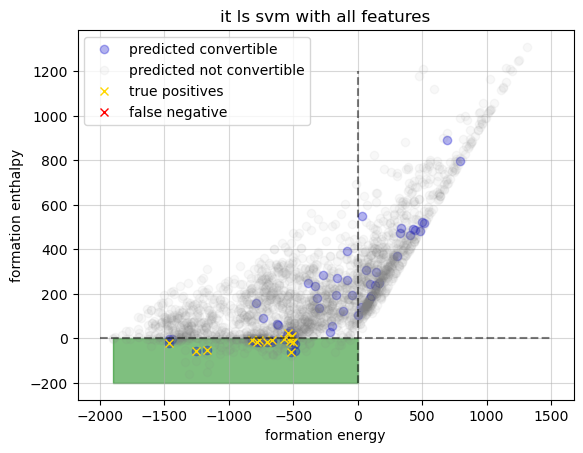

In [28]:
fig, ax = plt.subplots()

ax.plot(pred_pos['dEf'].to_numpy(),pred_pos['dH'].to_numpy(),'o', color='mediumblue', alpha=0.3,
         label='predicted convertible')
ax.plot(df_no_pos['dEf'].to_numpy(),df_no_pos['dH'].to_numpy(),'o',color='gray',alpha=0.05,
         label='predicted not convertible')
ax.plot(true_pos_to_plot['dEf'],true_pos_to_plot['dH'], 'x', color='gold',
        label='true positives')
ax.plot(df_false_negatives['dEf'],df_false_negatives['dH'], 'x', color='red',
        label='false negative')
ax.plot(np.linspace(-2000,1500,2,endpoint=True),np.zeros(2),'--k',alpha=0.5)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'--k',alpha=0.5)
ax.fill_between(np.linspace(np.min(df_no_pos['dEf'].to_numpy()),0,2,endpoint=True),y1=-200,y2=0,color='green',alpha=0.5)
ax.grid(alpha=0.5)
ax.set_xlabel(xlabel='formation energy')
ax.set_ylabel(ylabel='formation enthalpy')
ax.set_title('it ls svm with all features')
plt.legend()
#plt.savefig('it_ls_svm_pred_l_50_r_10_corr.png')

In [29]:
print(compteur)

3


In [30]:
true_pos_to_plot

,M_M_atomic_number,M_M_atomic_mass,M_M_molar_volume,M_M_density,M_M_atomic_radius,M_M_atomic_radius_calculated,M_M_van_der_waals_radius,M_M_average_ionic_radius,M_M_average_cationic_radius,M_M_average_anionic_radius,...,a_g_15,a_g_16,m_g_3,m_g_4,m_g_5,m_g_6,m_g_7,m_g_8,to_det_b,final_relab
Ti3AlC2,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.997760,1.0
Ti4AlN3,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.989056,1.0
Nb4AlC3,41,92.90638,10,9.290638,1.45,1.98,2.18,0.820000,0.820000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.986683,1.0
Ta4AlC3,73,180.94788,10,18.094788,1.45,2.00,2.22,0.820000,0.820000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.981875,1.0
Ti3SnC2,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.971652,1.0
V2AlC,23,50.94150,10,5.094150,1.35,1.71,2.07,0.777500,0.777500,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.971641,1.0
Ti3ZnC2,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.971641,1.0
Ti2ZnC,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.971641,1.0
Ti2SC,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.971641,1.0
Ti2AlC,22,47.86700,10,4.786700,1.40,1.76,2.11,0.851667,0.851667,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.971641,1.0
